# Production, Feed Capacity, Replacement Heifers, Inventory

In [15]:
import pandas as pd
import src

import warnings
warnings.filterwarnings('ignore')

#### Production (LB)

In [2]:
production = pd.read_csv('csv/production_incl_calves.csv')
production = src.usda_clean_annual(production)

<AxesSubplot:title={'center':'Production (LB)'}, ylabel='Value'>

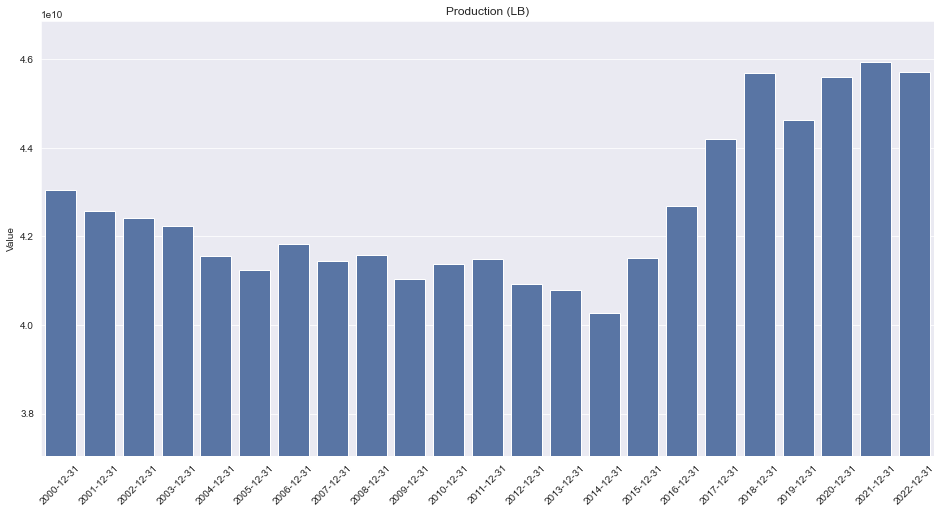

In [3]:
src.barplot(production, title="Production (LB)", ylim=0.1)

In [4]:
live_cattle_futures = pd.read_csv('csv/live_cattle_futures.csv')
live_cattle_futures = src.clean_tv_data(live_cattle_futures)
adj_live_cattle_futures = src.adjust_series_cpi(live_cattle_futures)

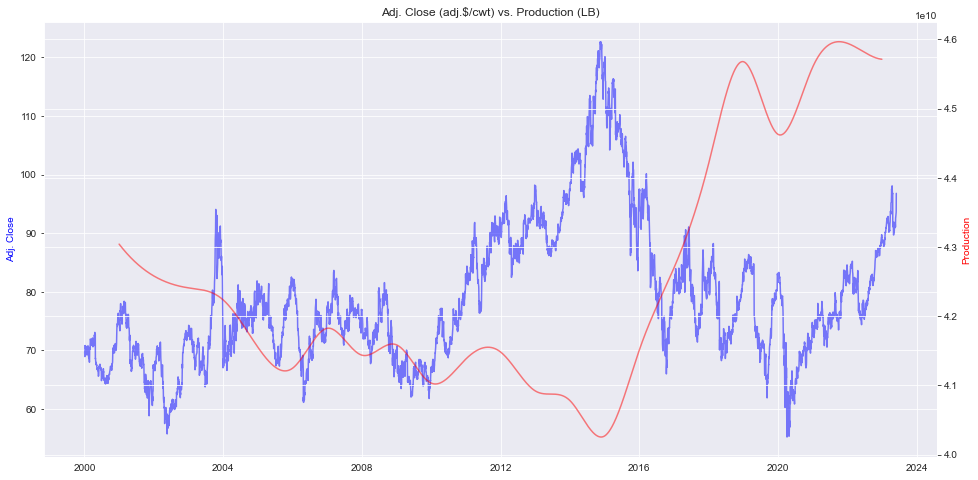

In [5]:
src.lineplot_2_own_axis(
    adj_live_cattle_futures,
    src.cubicspline(production),
    'Adj. Close',
    'Production',
    title='Adj. Close (adj.$/cwt) vs. Production (LB)'
    )

No handles with labels found to put in legend.


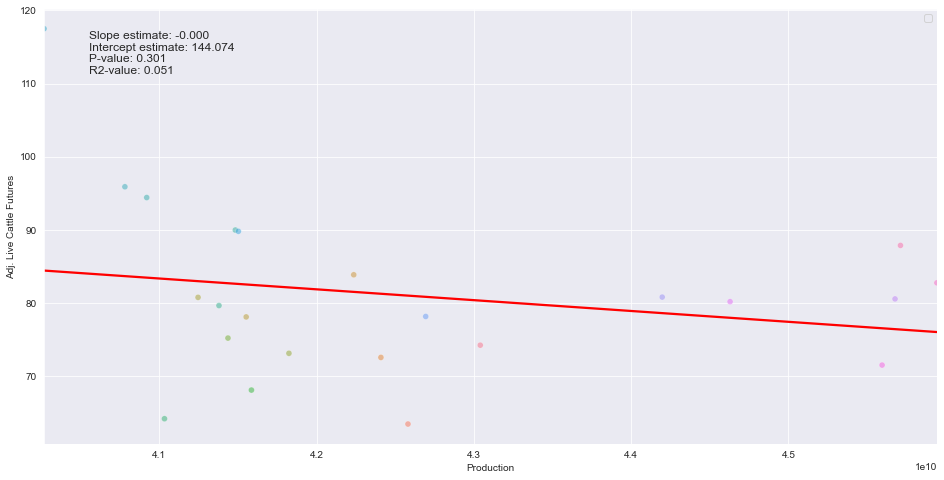

In [6]:
src.scatterplot(
    production.resample('M').mean(),
    adj_live_cattle_futures.resample('M').mean(),
    'Production',
    'Adj. Live Cattle Futures',
    reg=True
)

#### Feed Capacity (Head)

In [7]:
feed_capacity = pd.read_csv('csv/feed_capacity.csv')
feed_capacity = src.usda_clean_annual(feed_capacity, end_of_year=False)

<AxesSubplot:title={'center':'Feed Capacity (Head)'}, ylabel='Value'>

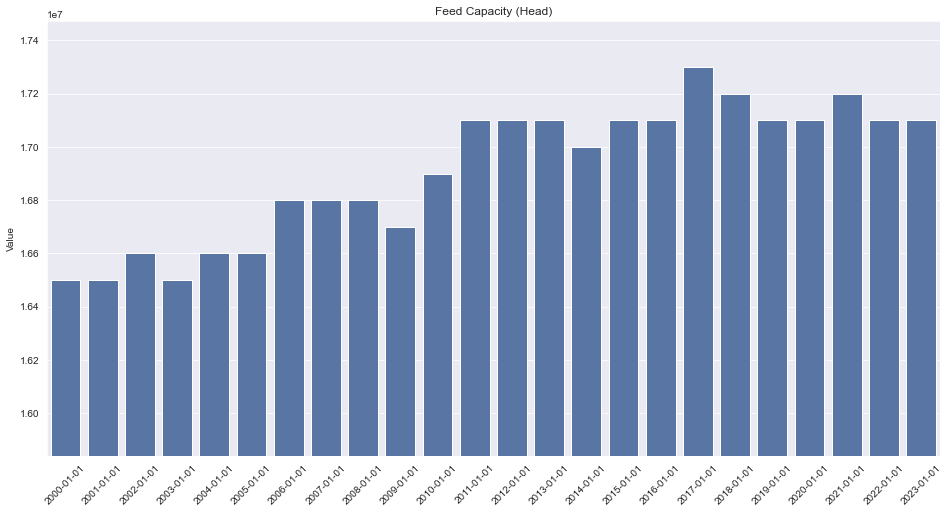

In [8]:
src.barplot(feed_capacity, ylim=0.05, title="Feed Capacity (Head)")

### Replacement Heifers (Head)

In [9]:
inv_heifers_ge_500_beef_repl = pd.read_csv('csv/inventory_heifers_ge_500_beef_repl.csv')
inv_heifers_ge_500_beef_repl = src.usda_clean_biannual(inv_heifers_ge_500_beef_repl)

<AxesSubplot:title={'center':'CATTLE, HEIFERS, GE 500 LBS, BEEF REPLACEMENT - INVENTORY'}>

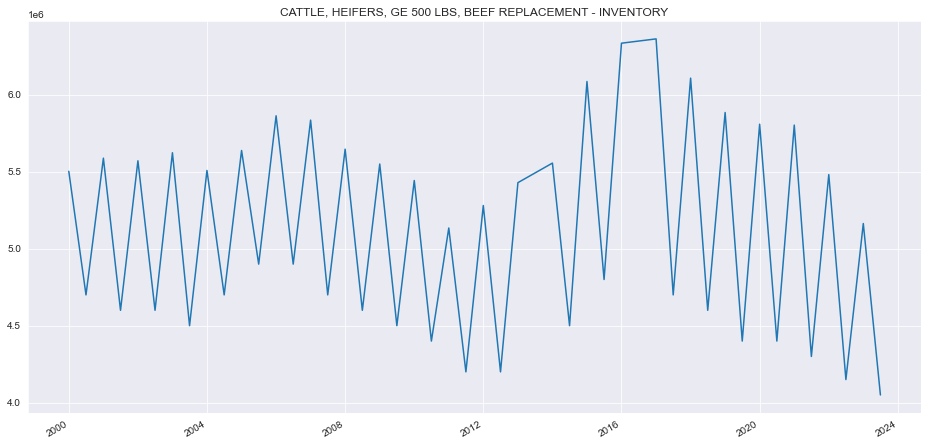

In [10]:
inv_heifers_ge_500_beef_repl.plot(title='CATTLE, HEIFERS, GE 500 LBS, BEEF REPLACEMENT - INVENTORY')

<AxesSubplot:title={'center':'Beef Replacement Heifers (Head)'}>

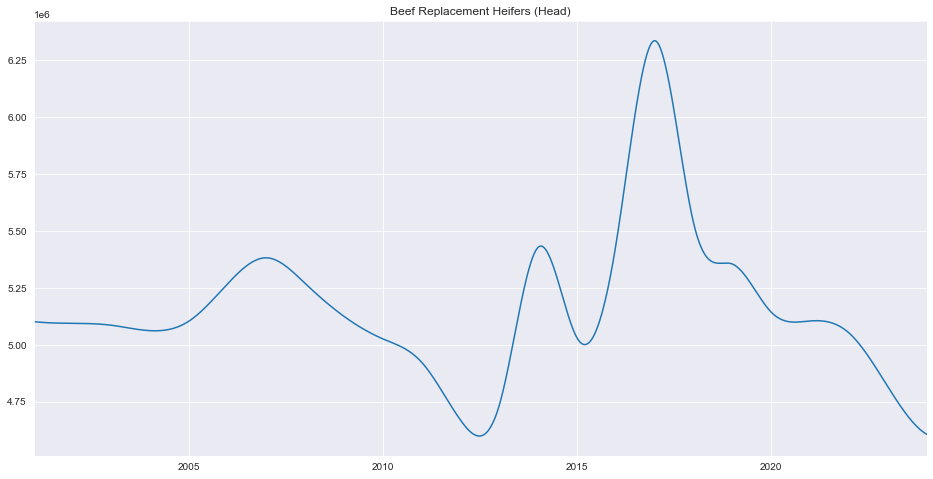

In [11]:
src.cubicspline(inv_heifers_ge_500_beef_repl.resample('Y').mean()).plot(title='Beef Replacement Heifers (Head)')

- Heifers are clearly not being retained

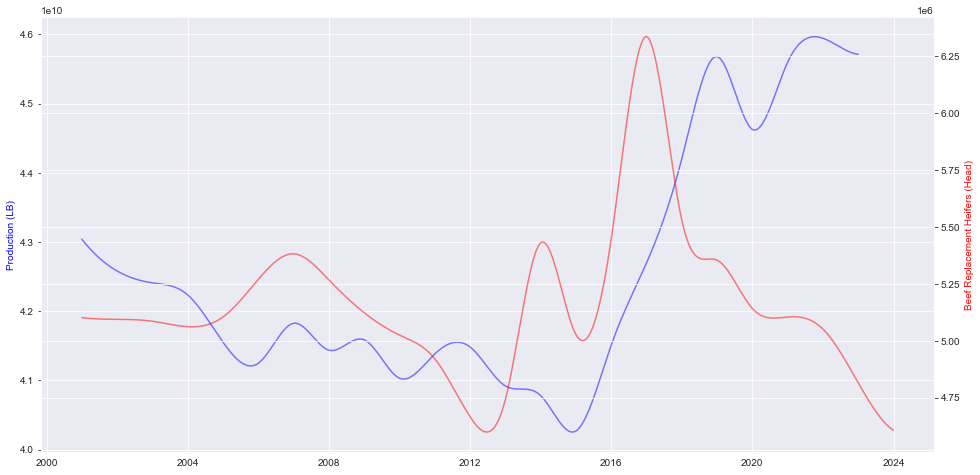

In [12]:
src.lineplot_2_own_axis(
    src.cubicspline(production.resample('Y').mean()),
    src.cubicspline(inv_heifers_ge_500_beef_repl.resample('Y').mean()),
    'Production (LB)',
    'Beef Replacement Heifers (Head)'
)

#### Inventory (Head)

<AxesSubplot:>

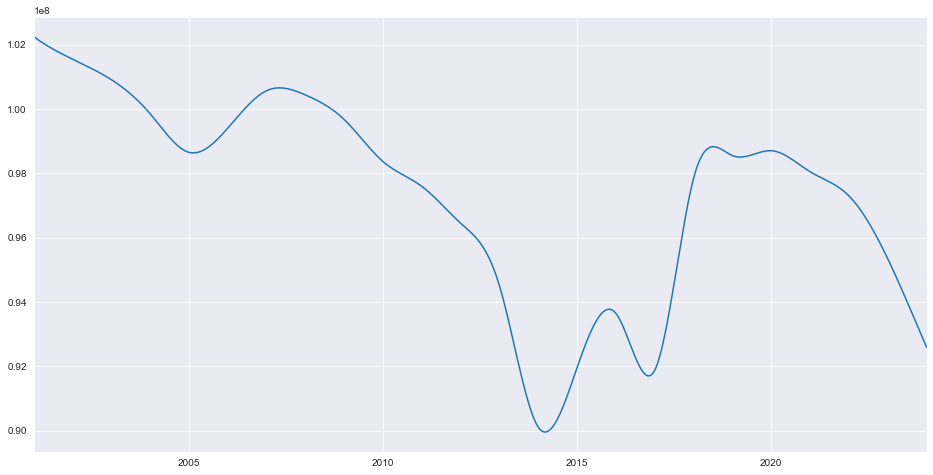

In [13]:
inv_incl_calves = pd.read_csv('csv/inventory_incl_calves.csv')
inv_incl_calves = src.usda_clean_biannual(inv_incl_calves)
src.cubicspline(inv_incl_calves.resample('Y').mean()).plot()

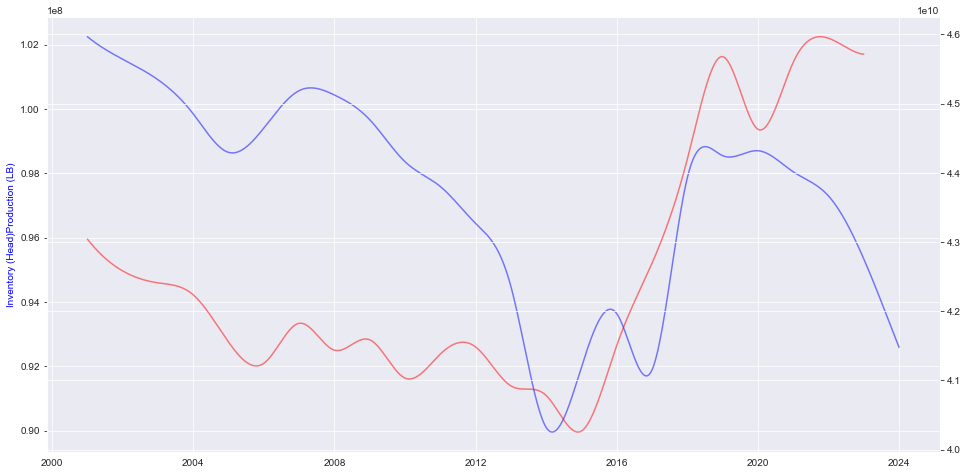

In [14]:
src.lineplot_2_own_axis(
    src.cubicspline(inv_incl_calves.resample('Y').mean()),
    src.cubicspline(production.resample('Y').mean()),
    'Inventory (Head)'
    'Production (LB)',
)